# Example 2a: Optical constant sources

In the first set of scripts focusing on the Si cell, we used different optical models to calculate total absorption
and absorption profiles. These absorption profiles are used by the electrical models (if using the DA or PDD model).
However, we didn't discuss what actually goes into these optical models, which are the optical constants (either the
complex refractive index, $n + i \kappa$ ($\kappa$ is the extinction coefficient), or equivalently the dielectric function
$\epsilon_1 + i \epsilon_2$). In these two examples we will discuss what these values are, how to get them, and how to model
them.

In [1]:
from solcore.absorption_calculator.nk_db import download_db, search_db, create_nk_txt
from solcore.absorption_calculator import calculate_rat, OptiStack
from solcore.material_system import create_new_material
from solcore import material
from solcore import si
from solcore.structure import Layer

import numpy as np
import matplotlib.pyplot as plt
from os import remove

import seaborn as sns

## Adding custom materials

If we want to use a material which is not in Solcore's database, or perhaps we want to use measured data rather than
data from a literature source, we can add a material to the database. We need to have n and k data, and (optionally)
a parameter file in the correct format - see examples of parameter files in e.g. material_data/Adachi/binaries.txt inside
Solcore's source files. These parameter files contain things like the bandgap, lattice constant, effective carrier masses,
etc.

Here, we create a new material, silicon-germanium-tin, from input files. Here, the parameters in SiGeSn_params.txt have
been copied directly from Ge. The last argument, with the parameters file, is optional; if you exclude it the material
will be added with just the n and k values and no further information specified (useful if you just want to do optical
calculations).

In [2]:
create_new_material('SiGeSn', 'data/SiGeSn_n.txt', 'data/SiGeSn_k.txt', 'data/SiGeSn_params.txt')

When adding custom materials - or getting the refractive index database - the information will be stored by default in
your home directory. You can change thethe SOLCORE_USER_DATA environmental variable in the config file to your prefered
location or, by default, it will be in your home directory, in a (hidden) directory called .solcore.

We can now create an instance of it like any Solcore material:

In [3]:
wl = si(np.arange(300, 1700, 5), 'nm')

SiGeSn = material('SiGeSn')()
Ge = material('Ge')()

**PLOT 1**: Comparing the optical constants of SiGeSn and Ge.

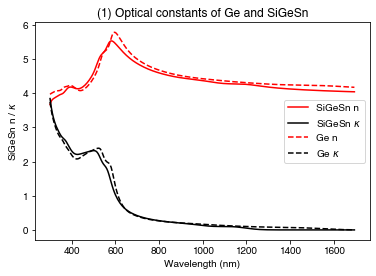

In [4]:
plt.figure()
plt.plot(wl*1e9, SiGeSn.n(wl), 'r-', label='SiGeSn n')
plt.plot(wl*1e9, SiGeSn.k(wl), 'k-', label=r'SiGeSn $\kappa$')

plt.plot(wl*1e9, Ge.n(wl), 'r--', label='Ge n')
plt.plot(wl*1e9, Ge.k(wl), 'k--', label=r'Ge $\kappa$')

plt.xlabel('Wavelength (nm)')
plt.ylabel(r'SiGeSn n / $\kappa$')
plt.legend()
plt.title("(1) Optical constants of Ge and SiGeSn")
plt.show()


## Using the refractiveindex.info database

Solcore can also directly interface with the database from [www.refractiveindex.info](https://www.refractiveindex.info), which contains around 3000
sets of $n$/$\kappa$ data for a large number of different materials. Before the first use, it is necessary to download the database.
This only needs to be done once, so you can comment this line out after it's done:


In [5]:
download_db()

Now we can search the database to select an appropriate entry. Search by element/chemical formula, or by the name of
the author who published the data.
In this case, we look for silver.

In [6]:
search_db('Ag', exact=True); # semicolon suppresses additional output in Jupyter Notebook. Do not need to use.

Database file found at /Users/phoebe/.solcore/nk/nk.db
17 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
0	main	Ag	Johnson	main/Ag/Johnson.yml	1	1	0.1879	1.937	49
1	main	Ag	Choi	main/Ag/Choi.yml	1	1	1.231	6.988	84
2	main	Ag	Jiang	main/Ag/Jiang.yml	1	1	0.3	2.0	1701
3	main	Ag	Yang	main/Ag/Yang.yml	1	1	0.27	24.92	525
4	main	Ag	McPeak	main/Ag/McPeak.yml	1	1	0.3	1.7	141
5	main	Ag	Babar	main/Ag/Babar.yml	1	1	0.2066	12.4	69
6	main	Ag	Wu	main/Ag/Wu.yml	1	1	0.287493	0.999308	450
7	main	Ag	Werner	main/Ag/Werner.yml	1	1	0.017586	2.479684	150
8	main	Ag	Stahrenberg	main/Ag/Stahrenberg.yml	1	1	0.12782	0.49594	361
9	main	Ag	Windt	main/Ag/Windt.yml	1	1	0.00236	0.12157	36
10	main	Ag	Hagemann	main/Ag/Hagemann.yml	1	1	2.48e-06	248.0	148
11	main	Ag	Ciesielski	main/Ag/Ciesielski.yml	1	1	0.19077	20.912	333
12	main	Ag	Ciesielski-Ge	main/Ag/Ciesielski-Ge.yml	1	1	0.19077	20.912	333
13	main	Ag	Ciesielski-Ni	main/Ag/Ciesielski-Ni.yml	1	1	0.19077	15.811	332
14	

This prints out, line by line, matching entries. This shows us entries with
"pageid"s 0 to 16 correspond to silver.

Let's compare the optical behaviour of some of those sources:

- pageid = 0, Johnson
- pageid = 2, Jiang
- pageid = 4, McPeak
- pageid = 10, Hagemann
- pageid = 14, Rakic (BB)

(The pageid values listed here are for the 2021-07-18 version of the refractiveindex.info database; this can change with different versions of the database)

Now, we create instances of materials with the optical constants from the database. The name (when using Solcore's
built-in materials, this would just be the name of the material or alloy, like 'GaAs') is the pageid, AS A STRING, while
the flag nk_db must be set to True to tell Solcore to look in the previously downloaded database from refractiveindex.info

In [7]:
Ag_Joh = material(name='0', nk_db=True)()
Ag_Jia = material(name='2', nk_db=True)()
Ag_McP = material(name='4', nk_db=True)()
Ag_Hag = material(name='10', nk_db=True)()
Ag_Rak = material(name='14', nk_db=True)()
Ag_Sol = material(name='Ag')() # Solcore built-in (from SOPRA)

Now we plot the $n$ and $\kappa$ data. Note that not all the data covers the full wavelength range, so the $n$/$\kappa$ value gets extrapolated from the last point in the dataset to cover any missing values.

**PLOT 2**: $n$ and $\kappa$ values for Ag from different literature sources

Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/Johnson.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/Jiang.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/McPeak.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/Hagemann.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/Rakic-BB.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/Johnson.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/Jiang.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/McPeak.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/Hagemann.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ag/Rakic-BB.yml loaded.


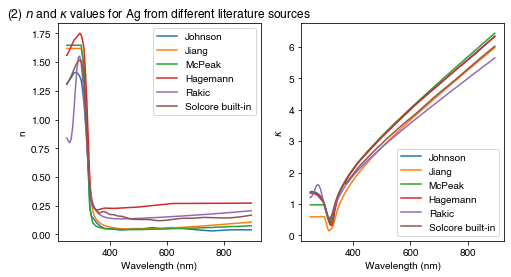

In [8]:
#| output: false

names = ['Johnson', 'Jiang', 'McPeak', 'Hagemann', 'Rakic', 'Solcore built-in']

wl = si(np.arange(250, 900, 5), 'nm')

plt.figure(figsize=(8,4))

plt.subplot(121)
# We can plot all the n values in one line:
plt.plot(wl*1e9, np.array([Ag_Joh.n(wl), Ag_Jia.n(wl), Ag_McP.n(wl),
                           Ag_Hag.n(wl), Ag_Rak.n(wl), Ag_Sol.n(wl)]).T);
plt.legend(labels=names)
plt.xlabel("Wavelength (nm)")
plt.title("(2) $n$ and $\kappa$ values for Ag from different literature sources")
plt.ylabel("n")

plt.subplot(122)
plt.plot(wl*1e9, np.array([Ag_Joh.k(wl), Ag_Jia.k(wl), Ag_McP.k(wl),
                           Ag_Hag.k(wl), Ag_Rak.k(wl), Ag_Sol.k(wl)]).T)
plt.legend(labels=names)
plt.xlabel("Wavelength (nm)")
plt.ylabel("$\kappa$")
plt.show()

Compare performance as a back mirror on a GaAs 'cell'; we make a solar cell-like structure with a very thin GaAs absorber (50 nm) and a silver back mirror.

**PLOT 3**: compare absorption in GaAs and Ag for a solar cell-like structure, using Ag data from different sources

Solid line: absorption in GaAs
Dashed line: absorption in Ag

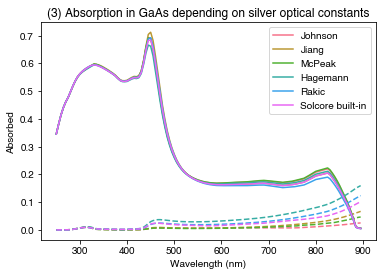

In [9]:
GaAs = material('GaAs')()

colors = sns.color_palette('husl', n_colors=len(names))

plt.figure()
for c, Ag_mat in enumerate([Ag_Joh, Ag_Jia, Ag_McP, Ag_Hag, Ag_Rak, Ag_Sol]):
    my_solar_cell = OptiStack([Layer(width=si('50nm'), material = GaAs)], substrate=Ag_mat)
    RAT = calculate_rat(my_solar_cell, wl*1e9, no_back_reflection=False)
    GaAs_abs = RAT["A_per_layer"][1]
    Ag_abs = RAT["T"]
    plt.plot(wl*1e9, GaAs_abs, color=colors[c], linestyle='-', label=names[c])
    plt.plot(wl*1e9, Ag_abs, color=colors[c], linestyle='--')

plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbed")
plt.title("(3) Absorption in GaAs depending on silver optical constants")
plt.show()

## Adding refractiveindex.info materials to Solcore's database

Finally, we can combine the two methods above and add a material from the refractiveindex.info database to Solcore's database.

The search_db function will print the search results, but it also creates a list of lists with details of all the search results. `results[0]` contains the first entry; `results[0][0]` is the 'pageid' of the first search result.

The function create_nk_txt creates files containing the optical constant data in the format required by Solcore. These are saved in the current working directory.

In [10]:
results = search_db('Diamond')

create_nk_txt(pageid=results[0][0], file='C_Diamond')

Database file found at /Users/phoebe/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
2897	3d	crystals	diamond	main/C/Phillip.yml	1	1	0.035424054	10.0	176
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/C/Phillip.yml loaded.
Wrote C_Diamond_n.txt
Wrote C_Diamond_k.txt


We now use these files to create a new material in the Solcore database:

In [11]:
create_new_material(mat_name='Diamond', n_source='C_Diamond_n.txt', k_source='C_Diamond_k.txt')

Material created with optical constants n and k only.


We can now delete the files with the Diamond data, since they have been copied into the user-defined materials directory:

In [12]:
remove("C_diamond_n.txt")
remove("C_diamond_k.txt")

Now we can use this material as we would any material from Solcore's database:

**PLOT 4**: Optical constants of diamond

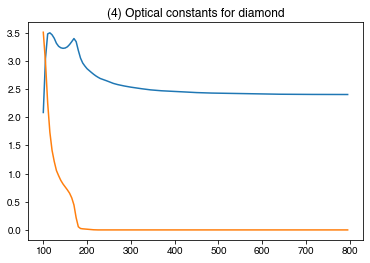

In [13]:
Diamond = material('Diamond')()

plt.figure()
plt.plot(si(np.arange(100, 800, 5), 'nm') * 1e9, Diamond.n(si(np.arange(100, 800, 5), 'nm')))
plt.plot(si(np.arange(100, 800, 5), 'nm') * 1e9, Diamond.k(si(np.arange(100, 800, 5), 'nm')))
plt.title("(4) Optical constants for diamond")
plt.show()

## Conclusions

So, we have at least 4 different ways of getting optical constants:

1. From Solcore's database
2. By adding our own material data to Solcore's database
3. By using the refractiveindex.info database directly
4. Similarly, we can add materials from the refractiveindex.info database to Solcore's database

If we add materials to the database, we can also choose to add non-optical parameters.